In [1]:
import os
os.getcwd()

'C:\\Users\\OM3D\\Desktop\\4_model'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, matthews_corrcoef, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
from itertools import combinations

O:\anaconda3\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('final.txt')
df = df.rename(columns={'pdockq1': 'pdockq2', 'pdockq2': 'pdockq1'})
selected_features = ['IntraclashesGroup1', 'IntraclashesGroup2', 'Interaction Energy',
       'Backbone Hbond', 'Sidechain Hbond', 'Van der Waals', 'Electrostatics',
       'Solvation Polar', 'Solvation Hydrophobic', 'Van der Waals clashes',
       'entropy sidechain', 'entropy mainchain', 'ptm_iptm',
       'pdockq2', 'pdockq1', 'backbone clash',
       'Interface Residues', 'pred_contact', 'Interface Residues Clashing', 'electrostatic kon',
       'Interface Residues BB Clashing', 'Interface Residues VdW Clashing','obs_contact'] #'Number of Residues'

In [3]:
# Make it binary by setting a threshold and split training and test
binary_obs_contact = np.where(df['obs_contact'] > 10, 1, 0)  # change here if necessary

pos_cor_features=[]
neg_cor_features=[]

### find the features with negative correlation
for feature in selected_features:
    #print(feature, np.corrcoef(binary_obs_contact,df[feature])[0][1])
    if np.corrcoef(binary_obs_contact,df[feature])[0][1] > 0:
        pos_cor_features.append(feature)
    else:
        neg_cor_features.append(feature)

In [4]:
def just_minmaxscale(df, feature):
    ### just scale within each structure
    #if feature in neg_cor_features: df[feature] = df[feature] * (-1)
    minimum = df[feature].min()
    maximum = df[feature].max()
    SD = df[feature].std()
    Mean = df[feature].mean()
    n = len(set(df['chain1']).union(set(df['chain2'])))
    if maximum==minimum:
        df[feature] = df[feature]-df[feature]+0.5
    else:
        df[feature] = (df[feature]-minimum)/(maximum-minimum)
    return df

def ranked_minmaxscale(df, feature):
    ### just scale within each structure
    #if feature in neg_cor_features: df[feature] = df[feature] * (-1)
    df[feature] = df[feature].rank()
    minimum = df[feature].min()
    maximum = df[feature].max()
    SD = df[feature].std()
    Mean = df[feature].mean()
    n = len(set(df['chain1']).union(set(df['chain2'])))
    if maximum==minimum:
        df[feature] = df[feature]
    else:
        df[feature] = (df[feature]-minimum)/(maximum-minimum)
    return df

def ranked_normalscale(df, feature):
    ### just scale within each structure
    #if feature in neg_cor_features: df[feature] = df[feature] * (-1)
    df[feature] = df[feature].rank()
    minimum = df[feature].min()
    maximum = df[feature].max()
    SD = df[feature].std()
    Mean = df[feature].mean()
    n = len(set(df['chain1']).union(set(df['chain2'])))
    if maximum==minimum:
        df[feature] = df[feature]
    else:
        df[feature] = (df[feature]-Mean)/SD
    return df

def just_normalscale(df, feature):
    ### just scale within each structure
    #if feature in neg_cor_features: df[feature] = df[feature] * (-1)
    minimum = df[feature].min()
    maximum = df[feature].max()
    SD = df[feature].std()
    Mean = df[feature].mean()
    n = len(set(df['chain1']).union(set(df['chain2'])))
    if maximum==minimum:
        df[feature] = df[feature]
    else:
        df[feature] = (df[feature]-Mean)/SD
    return df

In [5]:
# prepare the modified Data
df2= pd.DataFrame()
df2['pair']=df['pair']
df2['pdb_id'] = df2['pair'].apply(lambda x: x.split('_')[0])
df2['chain1'] = df2['pair'].apply(lambda x: x.split('_')[1])
df2['chain2'] = df2['pair'].apply(lambda x: x.split('_')[3])

df2[selected_features]=df[selected_features]

for feature in selected_features:
    if feature not in ['obs_contact']:
        df2 = df2.groupby('pdb_id').apply(lambda x: ranked_minmaxscale(x, feature))
    

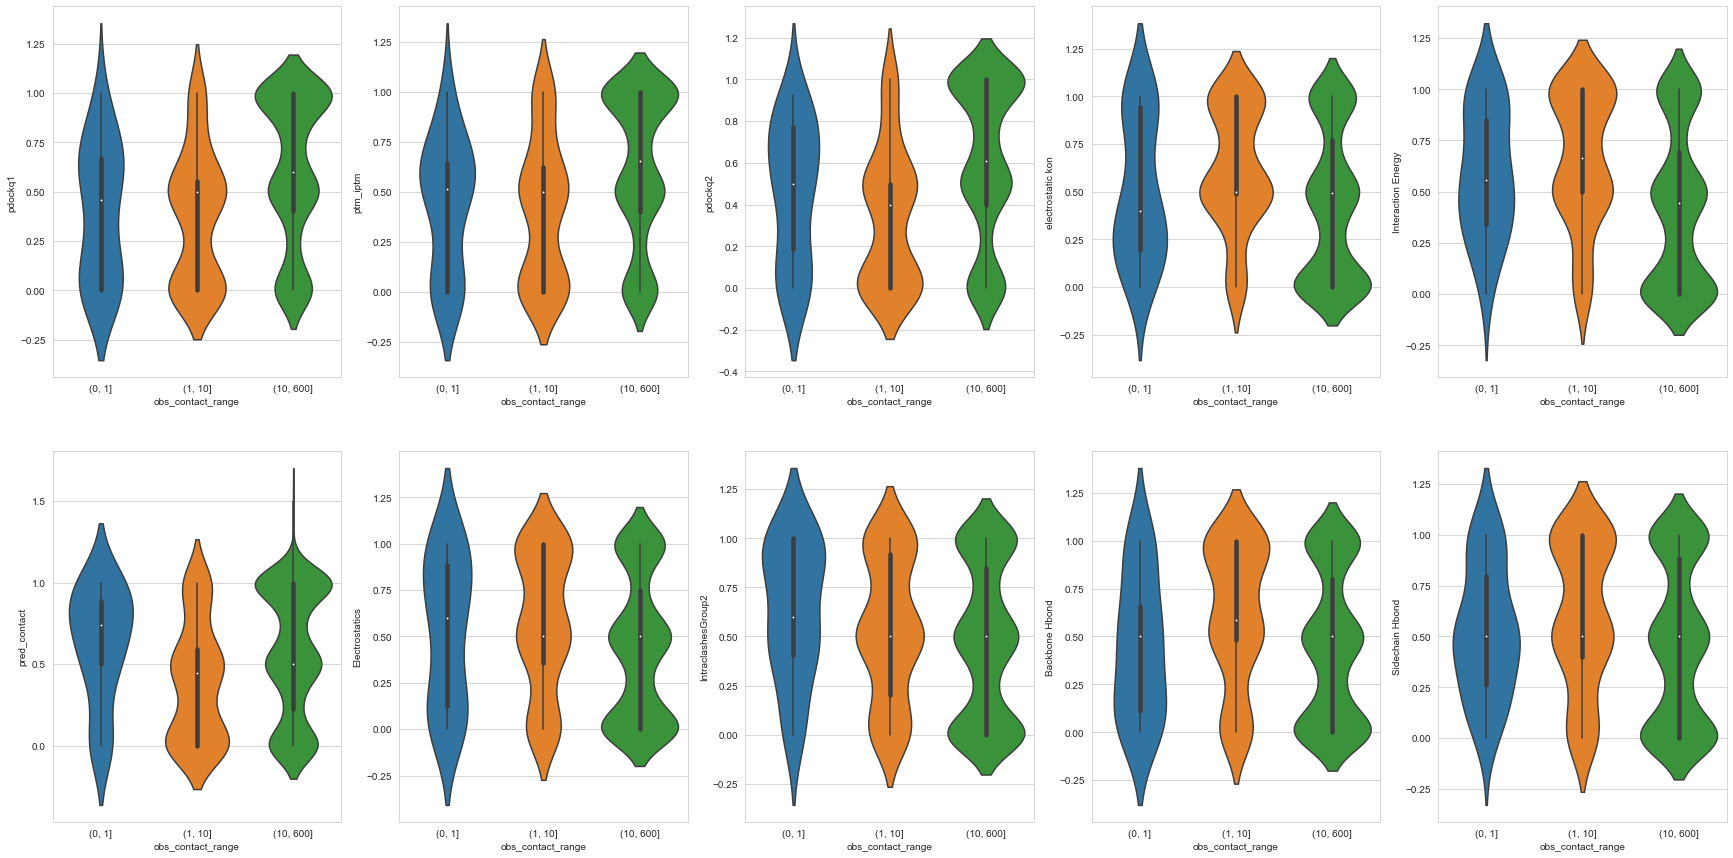

In [130]:
f,axs=plt.subplots(2,5,figsize=(30,15))
df2['obs_contact_range'] = pd.cut(df2['obs_contact'], [0, 1, 10, 600])
for i,feature in enumerate(top_features):
    row = i // 5
    col = i % 5
    ax = axs[row, col]
    sns.violinplot(x='obs_contact_range', y=feature, data=df2, ax=ax)

In [6]:
df2.columns

Index(['pair', 'pdb_id', 'chain1', 'chain2', 'IntraclashesGroup1',
       'IntraclashesGroup2', 'Interaction Energy', 'Backbone Hbond',
       'Sidechain Hbond', 'Van der Waals', 'Electrostatics', 'Solvation Polar',
       'Solvation Hydrophobic', 'Van der Waals clashes', 'entropy sidechain',
       'entropy mainchain', 'ptm_iptm', 'pdockq2', 'pdockq1', 'backbone clash',
       'Interface Residues', 'pred_contact', 'Interface Residues Clashing',
       'electrostatic kon', 'Interface Residues BB Clashing',
       'Interface Residues VdW Clashing', 'obs_contact'],
      dtype='object')

In [7]:
# Make it binary by setting a threshold
df2['binary_obs_contact'] = np.where(df['obs_contact'] > 10, 1, 0)  # change here if necessary
X = df2.drop(['chain1','chain2','pair','pdb_id','obs_contact', 'binary_obs_contact'], axis=1)
y = df2['binary_obs_contact']
# Split dataset into training and testing sets based on each structure complex
train_ids, test_ids = train_test_split(df2['pdb_id'].unique(), test_size=0.2, random_state=40)
X_train = df2[df2.pdb_id.isin(train_ids)].drop(['chain1','chain2','pair','pdb_id','obs_contact', 'binary_obs_contact'], axis=1) # features
X_test = df2[df2.pdb_id.isin(test_ids)].drop(['chain1','chain2','pair','pdb_id','obs_contact', 'binary_obs_contact'], axis=1) # features
y_train = df2[df2.pdb_id.isin(train_ids)]['binary_obs_contact'] # Target variable
y_test = df2[df2.pdb_id.isin(test_ids)]['binary_obs_contact'] # Target variable

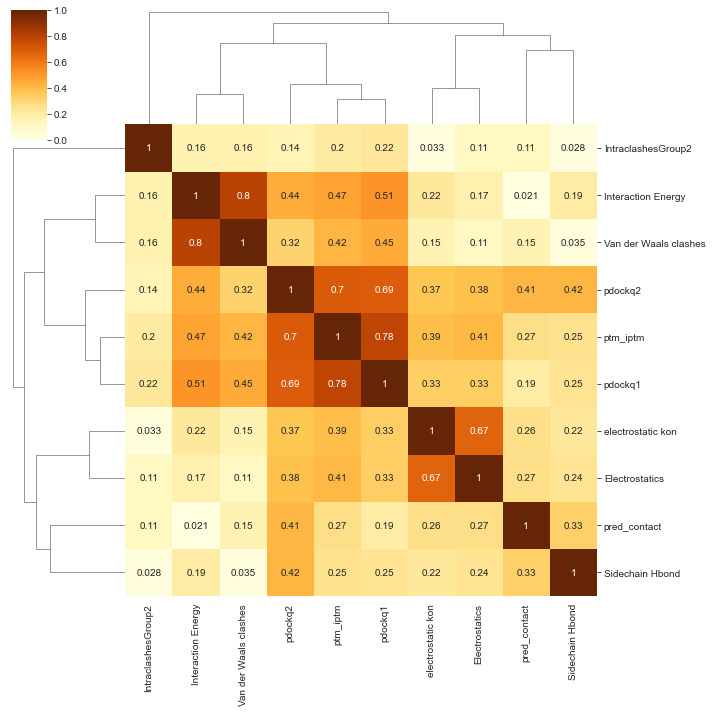

In [11]:
top_features=list(feature_names[indices][:10])
corr_matrix = np.abs(np.corrcoef(df2[top_features], rowvar=False))
sns.clustermap(corr_matrix, cmap="YlOrBr", xticklabels=top_features, yticklabels=top_features, annot=True, figsize=(10, 10), vmin=0, vmax=1)

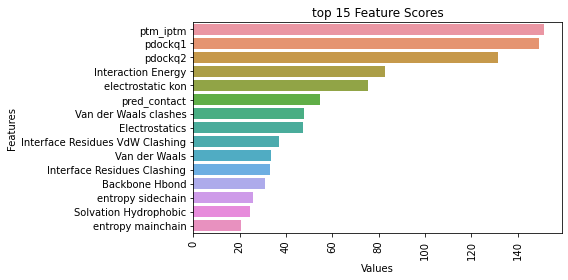

In [8]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=15)
X_train_new = selector.fit_transform(X_train, y_train)
X_test_new = selector.transform(X_test)
# print the selected features
selected_features=X.columns[selector.get_support()]
Selected_features_dic = {selected_features[i]:selector.scores_[selector.get_support()][i] for i in range(len(selected_features))}
sorted_features = sorted(Selected_features_dic, key=Selected_features_dic.get, reverse=True)  # Sort features based on values
values = [Selected_features_dic[feature] for feature in sorted_features]
plt.figure(figsize=(8, 4))
sns.barplot(x=values, y=sorted_features)  # Swapped x and y axes
plt.xlabel('Values')  # Swapped x and y labels
plt.ylabel('Features')  # Swapped x and y labels
plt.title('top 15 Feature Scores')
plt.xticks(rotation=90)  # Rotated x-axis labels
plt.tight_layout()  # Ensures labels are not cut off
plt.show()

Best n_estimators parameter:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
[[151  71]
 [ 47 150]]
MCC score:  0.44148038052889443
              precision    recall  f1-score   support

           0       0.76      0.68      0.72       222
           1       0.68      0.76      0.72       197

    accuracy                           0.72       419
   macro avg       0.72      0.72      0.72       419
weighted avg       0.72      0.72      0.72       419



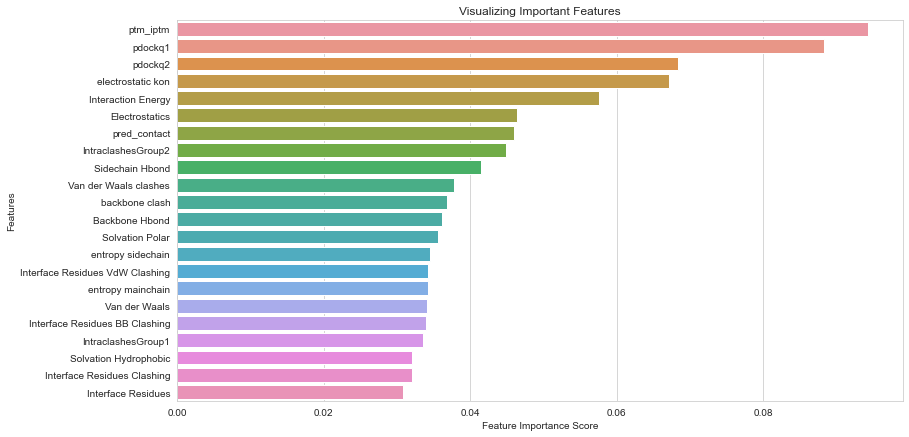

In [9]:
# Create a random forest model
rfc = RandomForestClassifier()

# Define parameter grid for grid search
param_grid = {'n_estimators': [100, 200],'max_depth': [5, 10, 20, None],'min_samples_split': [2, 5, 10],'max_features': ['auto', 'sqrt']}
#param_grid = {'n_estimators': [200],'max_depth': [None],'min_samples_split': [5],'max_features': ['sqrt']}
# Perform grid search with 4 cross folds
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, scoring='f1')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
# Print the best parameter and best score
#print("Best n_estimators parameter: ", best_params['n_estimators'])
print("Best n_estimators parameter: ", best_params)
#print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# fit a new model using the best hyperparameters
rf_best = RandomForestClassifier(**best_params)
rf_best.fit(X_train, y_train)
# Make prediction
y_pred = rf_best.predict(X_test)
# Report the performance evaluation
#print('Accuracy:', accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print ('MCC score: ',matthews_corrcoef(y_test, y_pred))
print(classification_report(y_test, y_pred))



feature_importances = rf_best.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]
# Get names of features and their importance scores
feature_names = X.columns
feature_importances = feature_importances[indices]
# Plot feature importances
sns.set_style("whitegrid")
plt.figure(figsize=(13, 7))
sns.barplot(x=feature_importances, y=feature_names[indices])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()


In [62]:
from keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from imblearn.over_sampling import SMOTE



def safe_mcc(y_true, y_pred):
    y_pred = tf.round(y_pred)
    y_true = tf.round(y_true)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    tn = tf.reduce_sum((1 - y_true) * (1 - y_pred))
    denom = K.sqrt((tp + fp + K.epsilon()) * (tp + fn + K.epsilon()) * (tn + fp + K.epsilon()) * (tn + fn + K.epsilon()))
    return (tp * tn - fp * fn) / denom
def f1_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    tn = tf.reduce_sum((1 - y_true) * (1 - y_pred))
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    weights = tf.reduce_sum(y_true, axis=0) / tf.reduce_sum(y_true)
    weighted_f1 = tf.reduce_sum(weights * f1)
    return weighted_f1


for i in range(3):
# Architecture
    model = Sequential()
    model.add(Dense(128, activation='relu'))  # Hidden layer with 10 neurons and ReLU activation
    model.add(Dropout(0.1))  # Dropout layer to prevent overfitting
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Precision(),Recall(), safe_mcc])
    # Add early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    # fit the model to the data
    model.fit(X_train, y_train, epochs=10, batch_size=32,verbose=0, validation_split=0.2, callbacks=[early_stopping])
# make predictions on new data
    loss, precision, recall, MCC= model.evaluate(X_test, y_test, verbose=0)
    print("Test loss: ", loss)
    print("Test MCC score: ", MCC)
    print("Test precision: ", precision)
    print("Test recall: ", recall)
    print('\n')

Test loss:  0.6944494247436523
Test MCC score:  0.28405120968818665
Test precision:  0.5714285969734192
Test recall:  0.8324872851371765


Test loss:  0.6338634490966797
Test MCC score:  0.31282705068588257
Test precision:  0.6007751822471619
Test recall:  0.7868020534515381


Test loss:  0.613980233669281
Test MCC score:  0.32997584342956543
Test precision:  0.618852436542511
Test recall:  0.7664974331855774


